In [1]:
import pertpy as pt
import scanpy as sc
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
from scipy import stats
from scipy import sparse 

from statsmodels.sandbox.stats.multicomp import multipletests


Installed version 0.4.0 of pertpy is newer than the latest release 0.3.0! You are running a nightly version and 
features may break!

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
%load_ext autoreload
%autoreload 2

import importlib
importlib.reload(pt)

Installed version 0.4.0 of pertpy is newer than the latest release 0.3.0! You are running a nightly version and 
features may break!

<module 'pertpy' from '/Users/tessa/miniforge3/envs/pertpy5/lib/python3.9/site-packages/pertpy/__init__.py'>

In [3]:
adata = sc.read_h5ad("zhang_with_PCs.h5ad")

In [4]:
def test_association(adata, celltype_label = "Cluster", sample_label="Sample", condition_label = "Efficacy", conditions_compare = ("PR","SD")): 
    pvals = pd.DataFrame(1, adata.obs[celltype_label].unique().tolist(), ["mcp_"+str(n) for n in range(0,10)])
    tstats = pd.DataFrame(1, adata.obs[celltype_label].unique().tolist(), ["mcp_"+str(n) for n in range(0,10)])
    response = adata.obs.groupby(sample_label)[condition_label].agg(pd.Series.mode)
    res = dict()
    for celltype in adata.obs[celltype_label].unique().tolist():
        df = adata.obs[adata.obs[celltype_label]==celltype]

        for mcpnum in ["mcp_"+str(n) for n in range(0,10)]:
            mns = df.groupby(sample_label)[mcpnum].mean()
            mns = pd.concat([mns,response],axis=1)
            res = stats.ttest_ind(mns[mns[condition_label]==conditions_compare[0]][mcpnum],mns[mns[condition_label]==conditions_compare[1]][mcpnum])
            pvals.loc[celltype, mcpnum]=res[1]
            tstats.loc[celltype, mcpnum]=res[0]
    return pvals,tstats



In [5]:
# tumor samples only
adata = adata[adata.obs['Origin']=="t" ,:].copy()

In [6]:
# pre-treatment samples only 
adata = adata[adata.obs['Sample'].str.contains('Pre'),:].copy()

In [7]:
# isecs = adata.obs.groupby(["Cluster", "Sample"]).size()
isecs = pd.crosstab(adata.obs['Cluster'], adata.obs['Sample'])

(array([ 5.,  8.,  6.,  1.,  8.,  3., 10.,  4.,  7.,  5.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

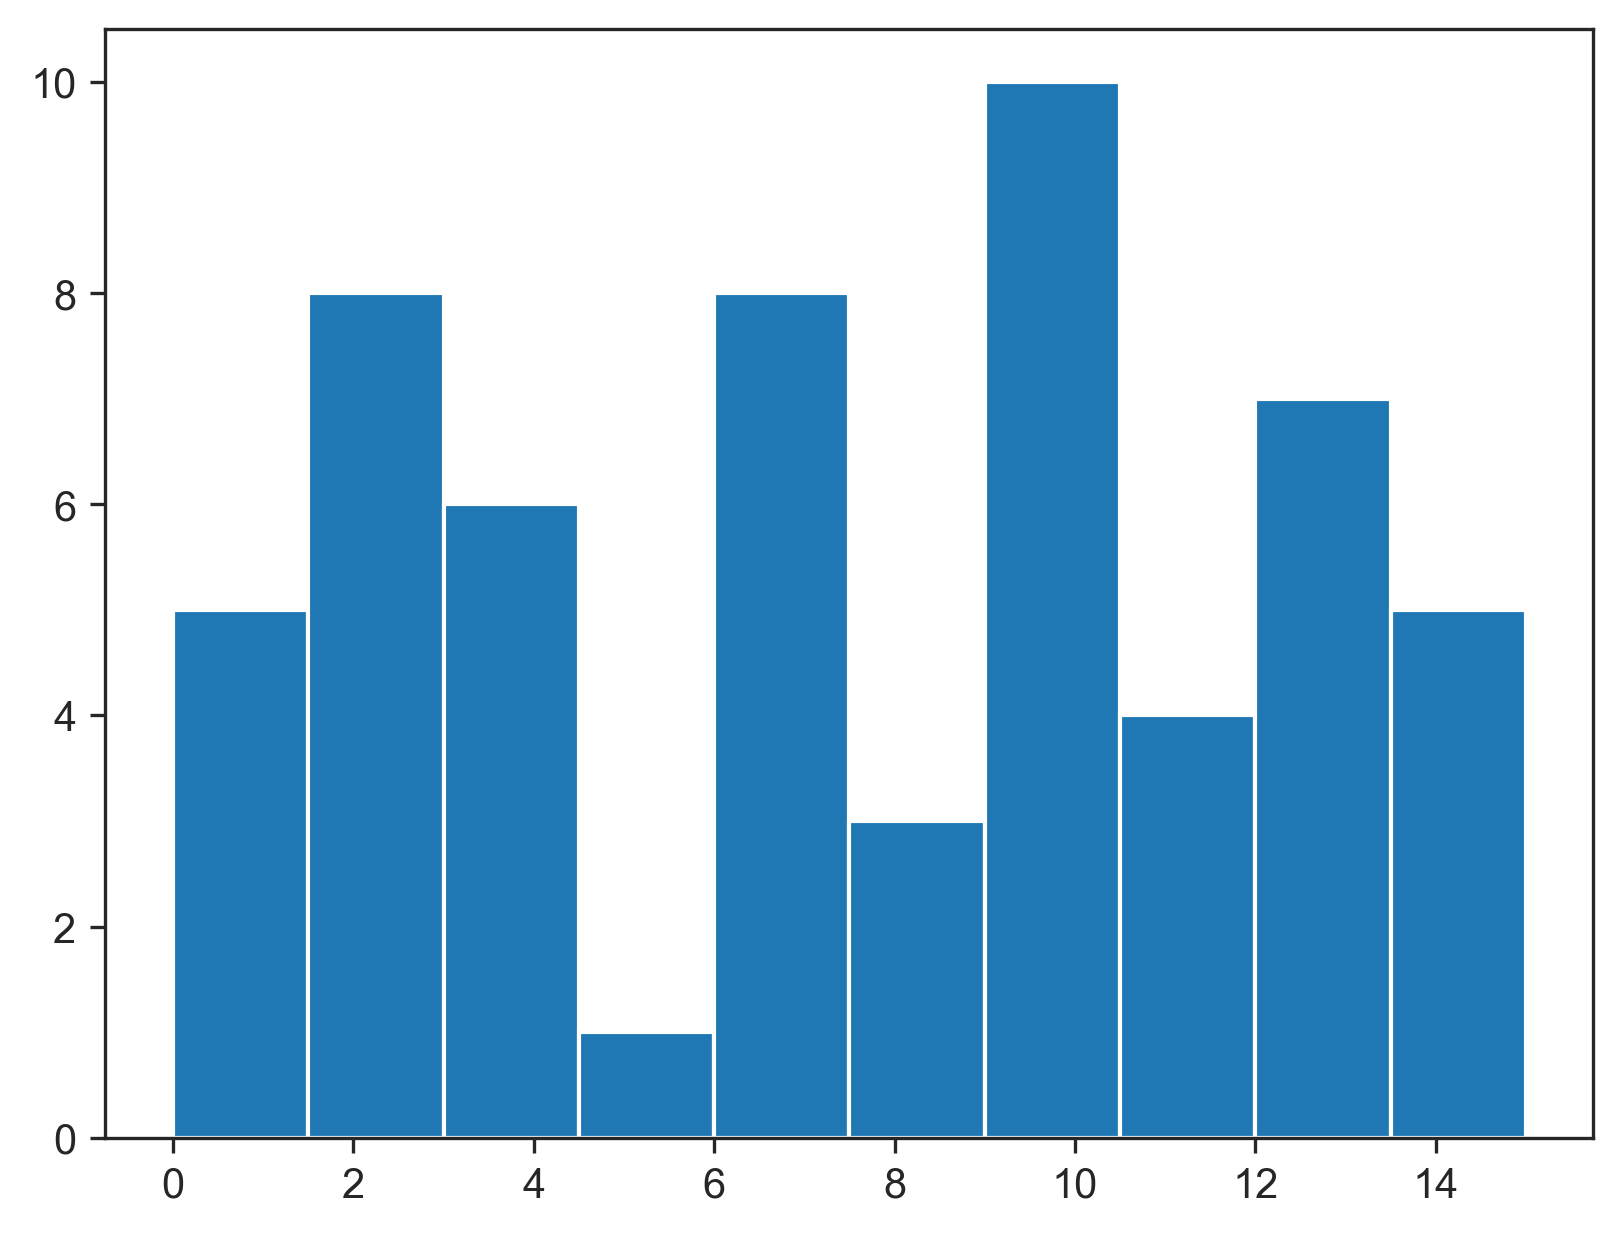

In [8]:
plt.hist((isecs >3).sum(axis=1))

In [9]:
isecs[(isecs > 3).sum(axis=1) == np.shape(isecs)[1]]

Sample      Pre_P002_t  Pre_P004_t  Pre_P005_t  Pre_P007_t  Pre_P010_t  \
Cluster                                                                  
t_pB-IGHG1         679           8          12          12           4   

Sample      Pre_P012_t  Pre_P013_t  Pre_P016_t  Pre_P017_t  Pre_P018_t  \
Cluster                                                                  
t_pB-IGHG1         301           4         136          14         238   

Sample      Pre_P019_t  Pre_P020_t  Pre_P022_t  Pre_P023_t  Pre_P025_t  
Cluster                                                                 
t_pB-IGHG1        1753         911        1083         206         283

In [10]:
isecs[(isecs > 3).sum(axis=1) == np.shape(isecs)[1]-1]

# drop sample Pre_P010_t 

Sample            Pre_P002_t  Pre_P004_t  Pre_P005_t  Pre_P007_t  Pre_P010_t  \
Cluster                                                                        
t_CD4_Tcm-LMNA             4         392         569         249           0   
t_CD4_Treg-FOXP3          13         338         110          62           0   
t_CD8_Tem-GZMK             8         957         368          72           0   
t_Tn-LEF1                 11          98         110        3494           0   

Sample            Pre_P012_t  Pre_P013_t  Pre_P016_t  Pre_P017_t  Pre_P018_t  \
Cluster                                                                        
t_CD4_Tcm-LMNA           288           6         311          20         134   
t_CD4_Treg-FOXP3         464          24         419          17         518   
t_CD8_Tem-GZMK           417          17         176          21         154   
t_Tn-LEF1               1269          22          50         609         167   

Sample            Pre_P019_t  Pre_P020_t  Pre_P022_t  Pre_P023_t  Pre_P025_t  
Cluster                                                                       
t_CD4_Tcm-LMNA           555          77         593         444          87  
t_CD4_Treg-FOXP3         769         743         398         122         130  
t_CD8_Tem-GZMK          2354         202         709         891         292  
t_Tn-LEF1               4010         175        1501         388         271

In [11]:
isecs[(isecs > 3).sum(axis=1) == np.shape(isecs)[1]-2]
# drop Pre_P013_t, Pre_P017_t, Pre_P002_2
# for this one we're doing just the 5 cell types with the most representation! 

Sample            Pre_P002_t  Pre_P004_t  Pre_P005_t  Pre_P007_t  Pre_P010_t  \
Cluster                                                                        
t_Bmem-CD27              377          11          12         105           0   
t_CD8_MAIT-KLRB1           0          51        1244          45           0   
t_CD8_Trm-ZNF683           3          76         180          71           0   
t_mono-FCN1                4          60          11          12           0   

Sample            Pre_P012_t  Pre_P013_t  Pre_P016_t  Pre_P017_t  Pre_P018_t  \
Cluster                                                                        
t_Bmem-CD27             1950           0          11         166          22   
t_CD8_MAIT-KLRB1          40           7          84          24          19   
t_CD8_Trm-ZNF683         143           4         407           4         226   
t_mono-FCN1               14          23          44           1          31   

Sample            Pre_P019_t  Pre_P020_t  Pre_P022_t  Pre_P023_t  Pre_P025_t  
Cluster                                                                       
t_Bmem-CD27             4210         132         309         121         400  
t_CD8_MAIT-KLRB1          67          14          38          20          11  
t_CD8_Trm-ZNF683         422         121         449         219         150  
t_mono-FCN1               43          15          51          33          16

In [12]:
celltypes = isecs[(isecs > 3).sum(axis=1) >= np.shape(isecs)[1]-1].index.values.to_list()

In [13]:
celltypes

['t_CD4_Tcm-LMNA',
 't_CD4_Treg-FOXP3',
 't_CD8_Tem-GZMK',
 't_Tn-LEF1',
 't_pB-IGHG1']

In [14]:
# subset to cell types with sufficient expression
adata = adata[adata.obs['Cluster'].isin(celltypes),:].copy()

In [15]:
adata

AnnData object with n_obs × n_vars = 32313 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [16]:
isecs = pd.crosstab(adata.obs['Cluster'], adata.obs['Sample'])

In [17]:
keep_pts = isecs.loc[:,(isecs > 3).sum(axis=0) == isecs.shape[0]].columns.values.to_list()

In [18]:
keep_pts

['Pre_P002_t',
 'Pre_P004_t',
 'Pre_P005_t',
 'Pre_P007_t',
 'Pre_P012_t',
 'Pre_P013_t',
 'Pre_P016_t',
 'Pre_P017_t',
 'Pre_P018_t',
 'Pre_P019_t',
 'Pre_P020_t',
 'Pre_P022_t',
 'Pre_P023_t',
 'Pre_P025_t']

In [19]:
adata = adata[adata.obs['Sample'].isin(keep_pts),:].copy()

In [20]:
pd.crosstab(adata.obs['Cluster'], adata.obs['Sample']).min(axis=1)

Cluster
t_CD4_Tcm-LMNA       4
t_CD4_Treg-FOXP3    13
t_CD8_Tem-GZMK       8
t_Tn-LEF1           11
t_pB-IGHG1           4
dtype: int64

In [21]:
pd.crosstab(adata.obs['Cluster'], adata.obs['Sample']).min(axis=0)

Sample
Pre_P002_t      4
Pre_P004_t      8
Pre_P005_t     12
Pre_P007_t     12
Pre_P012_t    288
Pre_P013_t      4
Pre_P016_t     50
Pre_P017_t     14
Pre_P018_t    134
Pre_P019_t    555
Pre_P020_t     77
Pre_P022_t    398
Pre_P023_t    122
Pre_P025_t     87
dtype: int64

In [20]:
# cell counts look passable (though definitely low for some -- could consider dropping more things)

In [22]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [22]:
adata.obs.columns

Index(['Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group',
       'Treatment', 'Number of counts', 'Number of genes', 'Major celltype',
       'Cluster'],
      dtype='object')

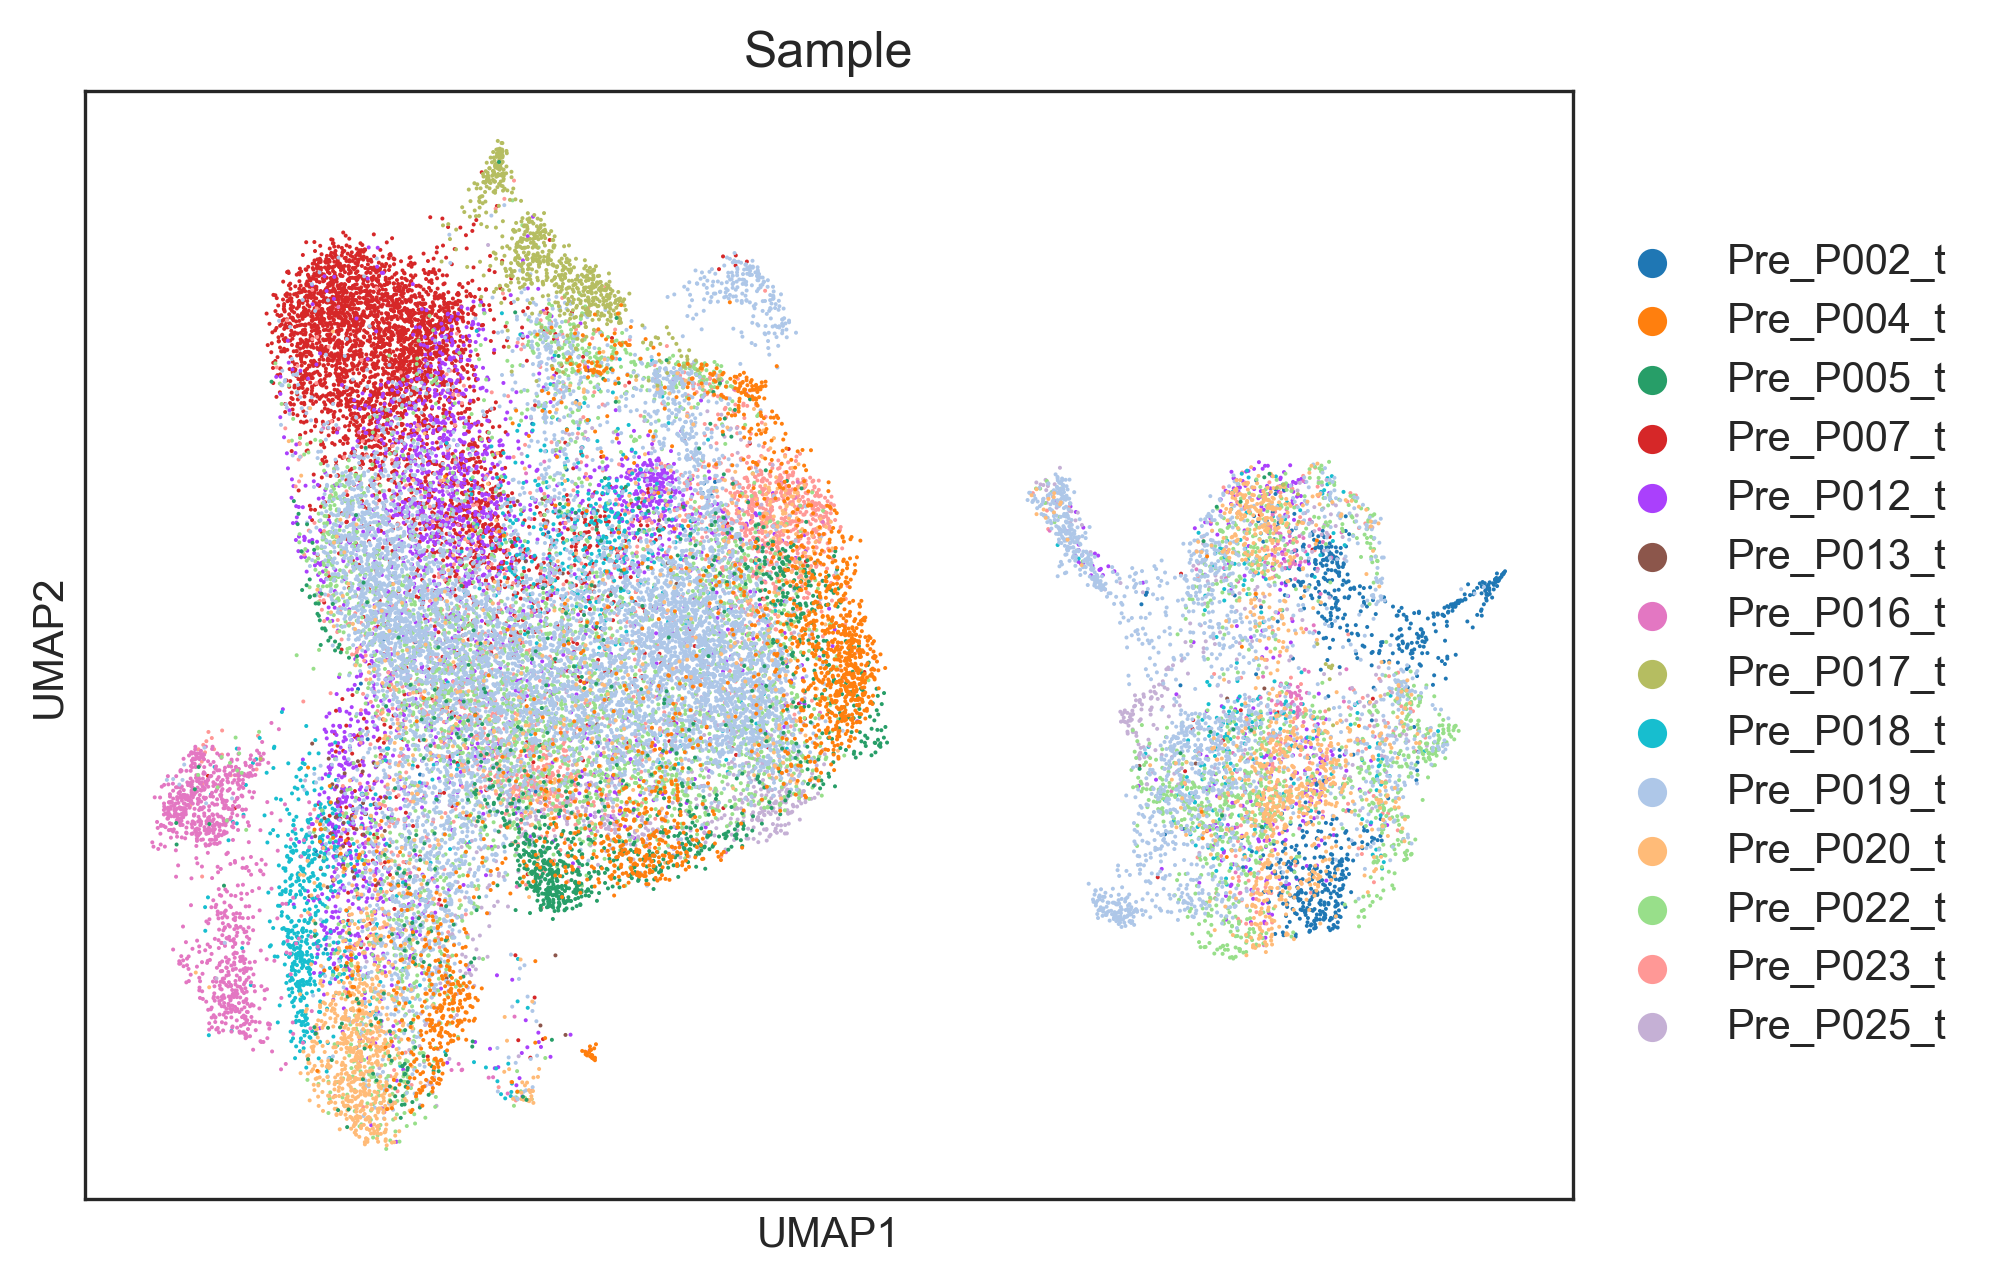

In [23]:
sc.pl.umap(
    adata,
    color=[
        "Sample"
    ],
)

# definitely sample splitting -- unclear if batch effect vs interpatient variation

In [25]:
sc.pl.umap(
    adata,
    color=[
        "Treatment"
    ],
)

In [ ]:
sc.pl.umap(
    adata,
    color=[
        "Cluster"
    ],
)

In [ ]:
sc.pl.umap(
    adata,
    color=[
        "Efficacy"
    ],
)

In [28]:
adata_1 = adata.copy()

dl_1 = pt.tl.Dialogue(sample_id = "Sample",
                   celltype_key = "Cluster",
                   n_counts_key = "Number of counts",
                   n_mpcs = 10)

adata_1, mcps_1, ws_1, ct_subs_1 = dl_1.calculate_multifactor_PMD(
    adata_1,
    normalize=False,
    solver="lp"
)

#adata, mcps, ws, ct_subs = dl.calculate_multifactor_PMD(
#    adata,
#    groupby='Sample',
#    celltype_key='Cluster',
#    mimic_dialogue=True,
#    n_components=10
#)

pvals_1, tstats_1 = test_association(adata_1)

In [29]:
pvals_1.min()

mcp_0    0.739905
mcp_1    0.741867
mcp_2    0.718719
mcp_3    0.730322
mcp_4    0.677695
mcp_5    0.648936
mcp_6    0.617352
mcp_7    0.512042
mcp_8    0.460426
mcp_9    0.415502
dtype: float64

In [30]:
adata_2 = adata.copy()

dl_2 = pt.tl.Dialogue(sample_id = "Sample",
                   celltype_key = "Cluster",
                   n_counts_key = "Number of counts",
                   n_mpcs = 10)

adata_2, mcps_2, ws_2, ct_subs_2 = dl_2.calculate_multifactor_PMD(
    adata_2,
    normalize=False,
    solver="lp"
)

#adata, mcps, ws, ct_subs = dl.calculate_multifactor_PMD(
#    adata,
#    groupby='Sample',
#    celltype_key='Cluster',
#    mimic_dialogue=True,
#    n_components=10
#)

pvals_2, tstats_2 = test_association(adata_2)

In [31]:
pvals_2.min()

mcp_0    0.739905
mcp_1    0.741867
mcp_2    0.718719
mcp_3    0.730322
mcp_4    0.677695
mcp_5    0.648936
mcp_6    0.617352
mcp_7    0.512042
mcp_8    0.460426
mcp_9    0.415502
dtype: float64

In [27]:
dl = pt.tl.Dialogue()

In [28]:
dl

In [30]:
adata, mcps, ws, ct_subs = dl.calculate_multifactor_PMD(
    adata,
    groupby='Sample',
    celltype_key='Cluster',
    mimic_dialogue=True,
    n_components=10
)

In [31]:
# need to implement automated chi-squared testing of efficacy w MCPs
# 
# also something for multiple testing correction

# and then need plotting utilities 
#  I'd like to get the pairs plots but need to decide which cells count as in MCP 

# also -- MCP membership -- how does that work here? 
# want to choose ones with decent correlations

In [32]:
adata

AnnData object with n_obs × n_vars = 32309 × 4000
    obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
    obsm: 'X_pca', 'X_umap'

In [33]:
mcps

{'t_CD4_Tcm-LMNA': array([[ -0.68343005,   0.15141608,   1.28045892, ...,   0.0949806 ,
          -0.67763472,  -0.29383075],
        [  0.09502469,  -2.43391195,   2.25519323, ...,  -4.04997453,
          -1.81456101,   1.0944652 ],
        [ -0.66775043,  -2.94753431,  -1.53935294, ...,  -1.97974299,
           0.56599583,   1.86324128],
        ...,
        [ -0.40719131, -10.05644525,   4.66474453, ...,  -1.60700342,
          -8.35938796,   2.45498619],
        [ -0.22620866,  -5.42816011,   4.40869743, ...,  -2.00402424,
          -4.15251001,   2.29142031],
        [  1.06663759,  -9.95268084,   1.88812565, ...,  -1.57869272,
          -6.49003656,   2.32141047]]),
 't_CD4_Treg-FOXP3': array([[-1.91037130e+00, -1.08190275e+01,  1.92935875e+00, ...,
         -2.53893042e+00, -2.38787764e-01,  7.82659832e-01],
        [-2.27437514e+00,  3.91424549e-01, -2.28799060e+00, ...,
          7.65372345e-01,  1.53128250e+00, -1.97692434e+00],
        [-2.67314220e+00, -5.54436101e+00,  1.4

In [34]:
sc.pl.umap(adata, color=[0, 1, 2,3,4,5,6,"Efficacy"], ncols=1, cmap='coolwarm', vcenter=0)


In [ ]:
adata

In [38]:
adata.obs.columns = adata.obs.columns.astype(str)

In [39]:
pvals = pd.DataFrame(1, adata.obs['Cluster'].unique().tolist(), [str(n) for n in range(0,10)])
tstats = pd.DataFrame(1, adata.obs['Cluster'].unique().tolist(), [str(n) for n in range(0,10)])
response = adata.obs.groupby('Sample')['Efficacy'].agg(pd.Series.mode)
res = dict()
for celltype in adata.obs['Cluster'].unique().tolist():
    df = adata.obs[adata.obs['Cluster']==celltype]

    for mcpnum in [str(n) for n in range(0,10)]:
        mns = df.groupby('Sample')[mcpnum].mean()
        mns = pd.concat([mns,response],axis=1)
        res = stats.ttest_ind(mns[mns['Efficacy']=='PR'][mcpnum],mns[mns['Efficacy']=='SD'][mcpnum])
        pvals.loc[celltype, mcpnum]=res[1]
        tstats.loc[celltype, mcpnum]=res[0]

In [40]:
res = stats.ttest_ind(mns[mns['Efficacy']=='PR']['1'],mns[mns['Efficacy']=='SD']['1'])

KeyError: '1'

In [ ]:
pvals # haven't multiple test corrected, but 4 and 8 look interesting

In [176]:
p_adjusted = multipletests(pvals.transpose()['t_CD4_Treg-FOXP3'], method='bonferroni')

In [178]:
# I'm not sure what makes sense a multiple testing correction here
# treating the MCPs as independent and doing bonferroni on a given cell type indicates no significant correlations

In [179]:
multipletests(pvals.transpose()['t_Bmem-CD27'], method='bonferroni')

(array([False, False, False, False, False, False, False, False, False,
        False]),
 array([1.        , 1.        , 1.        , 1.        , 0.08144188,
        1.        , 1.        , 1.        , 0.07457995, 1.        ]),
 0.005116196891823743,
 0.005)

In [181]:
multipletests(pvals.transpose()['t_Tn-LEF1'], method='bonferroni')

(array([False, False, False, False, False, False, False, False, False,
        False]),
 array([1.        , 1.        , 1.        , 1.        , 0.06156236,
        1.        , 1.        , 1.        , 0.30611572, 1.        ]),
 0.005116196891823743,
 0.005)

In [185]:
multipletests(pvals['4'], method='bonferroni')

(array([False, False, False, False, False, False, False, False, False]),
 array([0.07329769, 0.05015518, 0.21242086, 0.087883  , 0.18137732,
        0.15099661, 0.05540613, 0.57795322, 0.07848545]),
 0.005683044988048058,
 0.005555555555555556)

In [186]:
multipletests(pvals['8'], method='bonferroni')

(array([False, False, False, False, False, False, False, False, False]),
 array([0.06712195, 0.09490321, 1.        , 1.        , 0.51654228,
        0.1307671 , 0.27550415, 1.        , 0.39863003]),
 0.005683044988048058,
 0.005555555555555556)

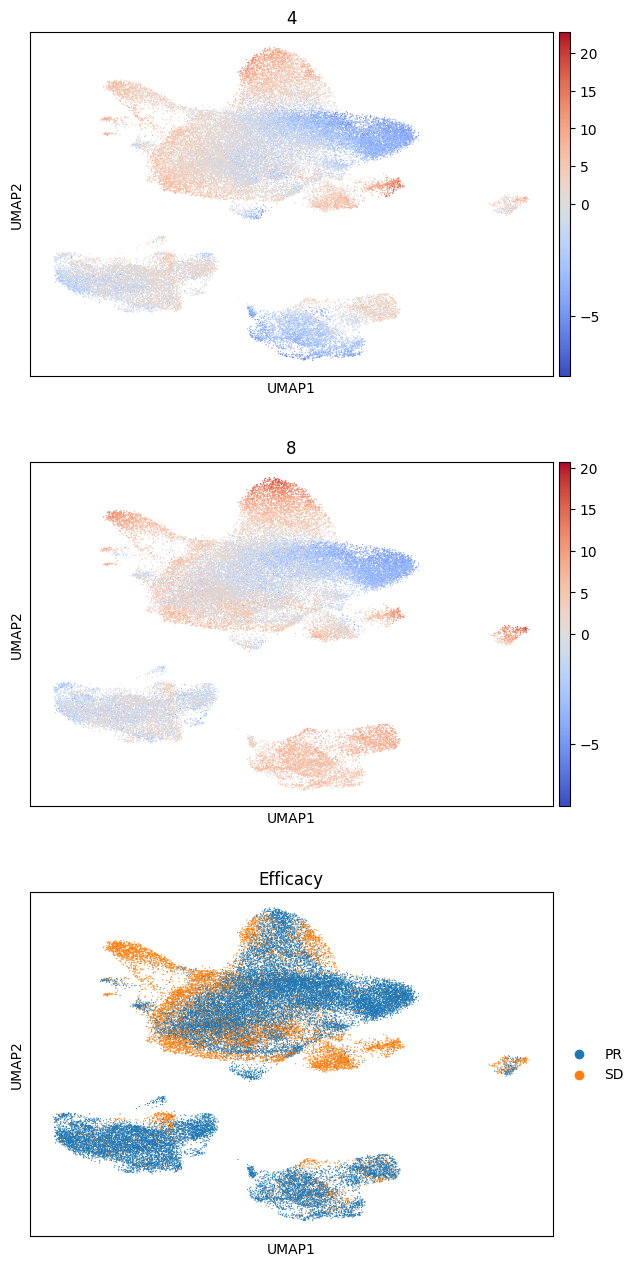

In [187]:
sc.pl.umap(adata, color=['4','8',"Efficacy"], ncols=1, cmap='coolwarm', vcenter=0)


[Text(0, 0, 't_Bmem-CD27'),
 Text(1, 0, 't_CD4_Tcm-LMNA'),
 Text(2, 0, 't_CD4_Treg-FOXP3'),
 Text(3, 0, 't_CD8_MAIT-KLRB1'),
 Text(4, 0, 't_CD8_Tem-GZMK'),
 Text(5, 0, 't_CD8_Trm-ZNF683'),
 Text(6, 0, 't_Tn-LEF1'),
 Text(7, 0, 't_mono-FCN1'),
 Text(8, 0, 't_pB-IGHG1')]

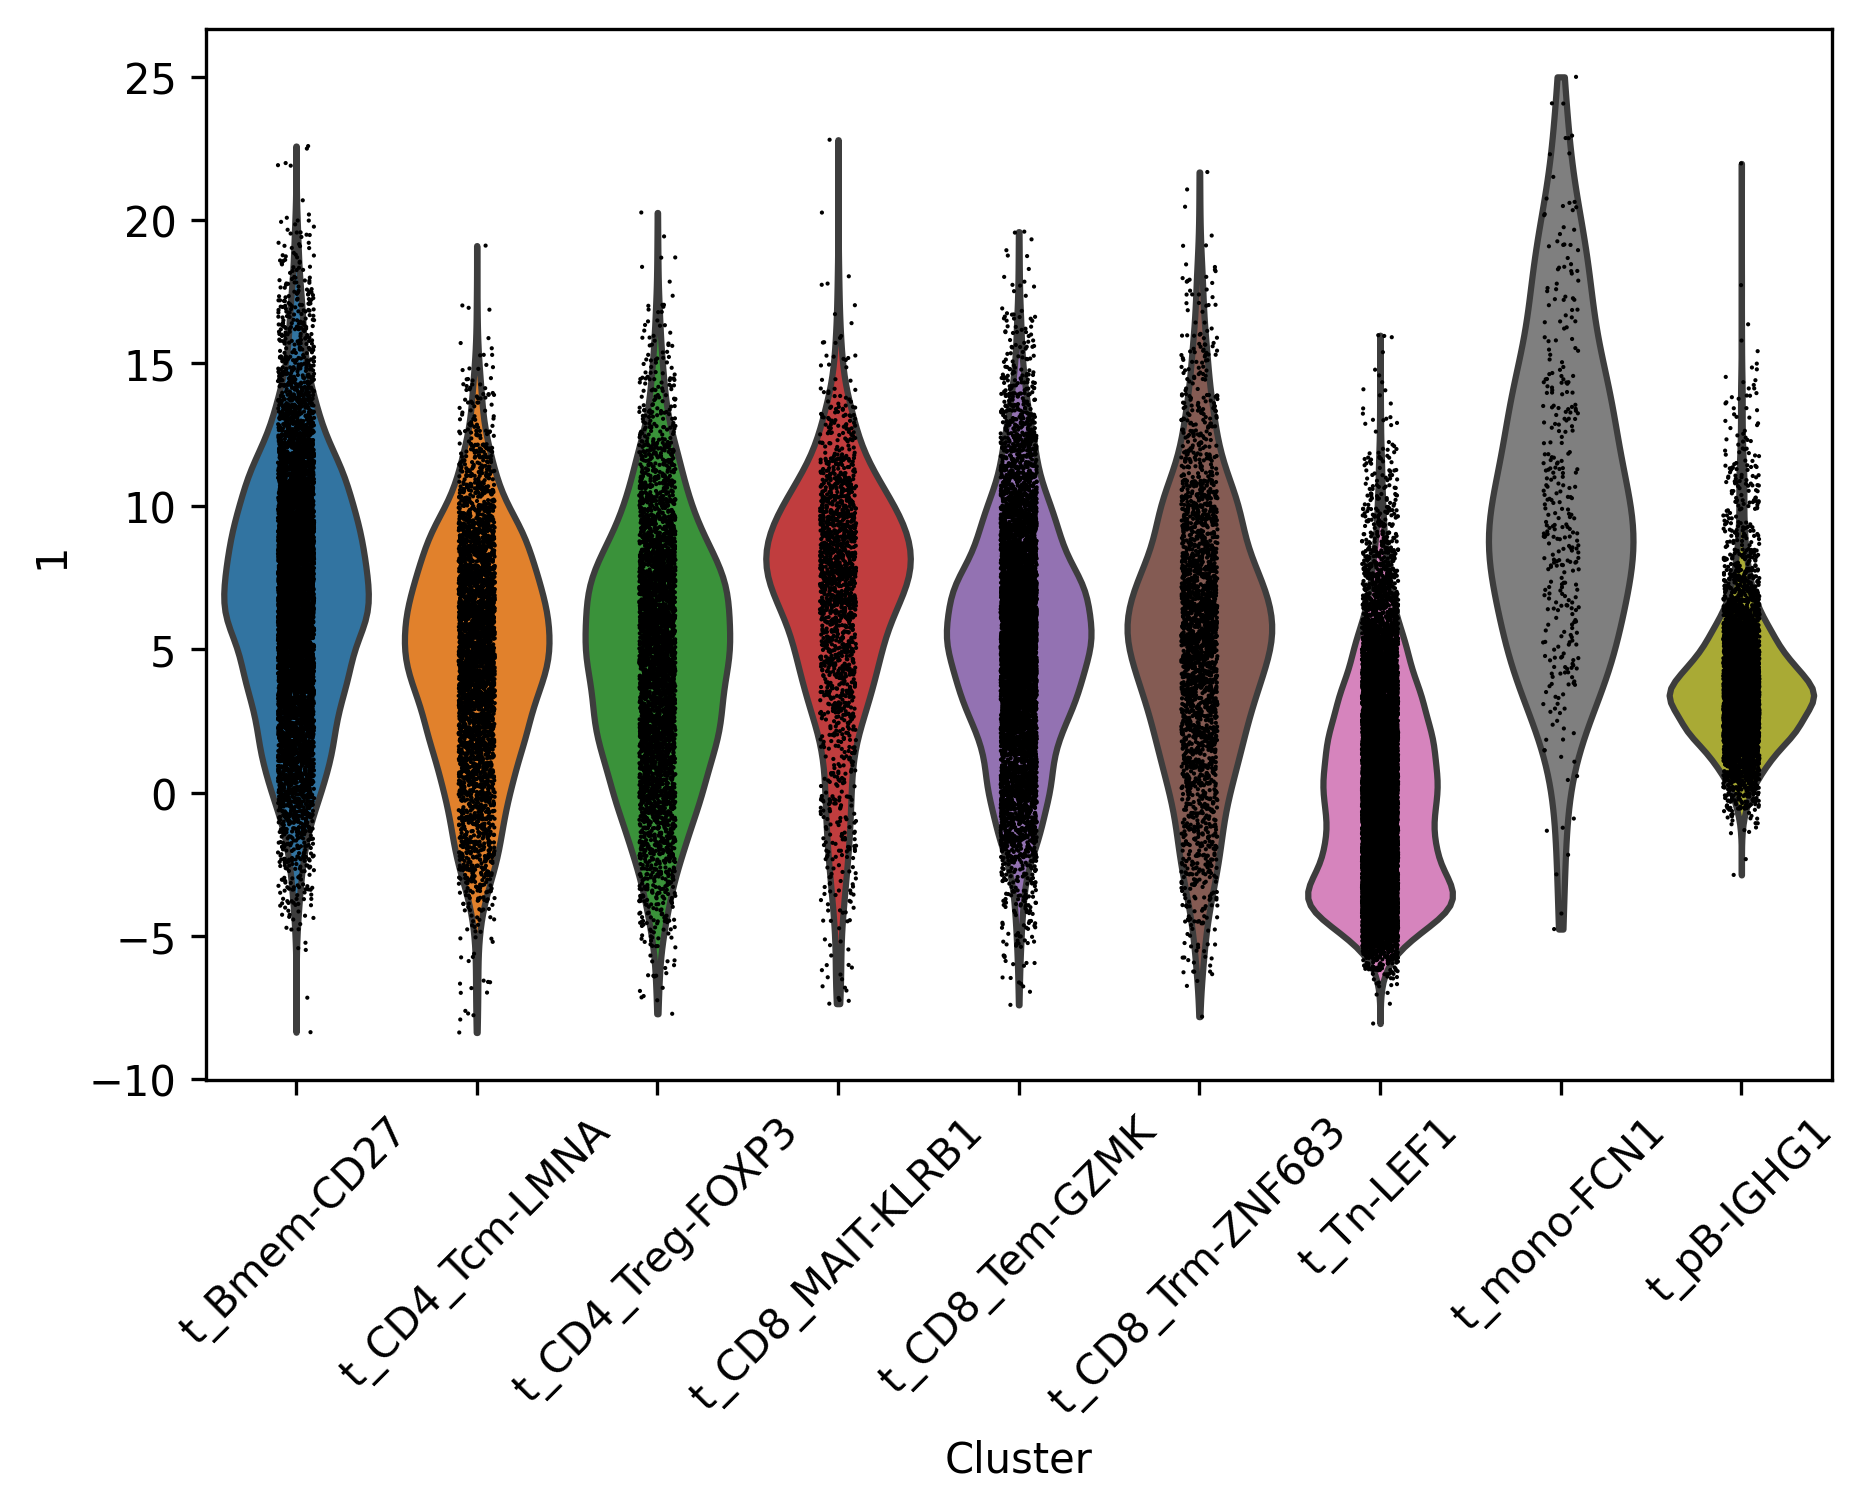

In [207]:
p = sc.pl.violin(adata, '1', groupby= "Cluster", show=False)
p.set_xticklabels(p.get_xticklabels(), rotation=45)



[Text(0, 0, 't_Bmem-CD27'),
 Text(1, 0, 't_CD4_Tcm-LMNA'),
 Text(2, 0, 't_CD4_Treg-FOXP3'),
 Text(3, 0, 't_CD8_MAIT-KLRB1'),
 Text(4, 0, 't_CD8_Tem-GZMK'),
 Text(5, 0, 't_CD8_Trm-ZNF683'),
 Text(6, 0, 't_Tn-LEF1'),
 Text(7, 0, 't_mono-FCN1'),
 Text(8, 0, 't_pB-IGHG1')]

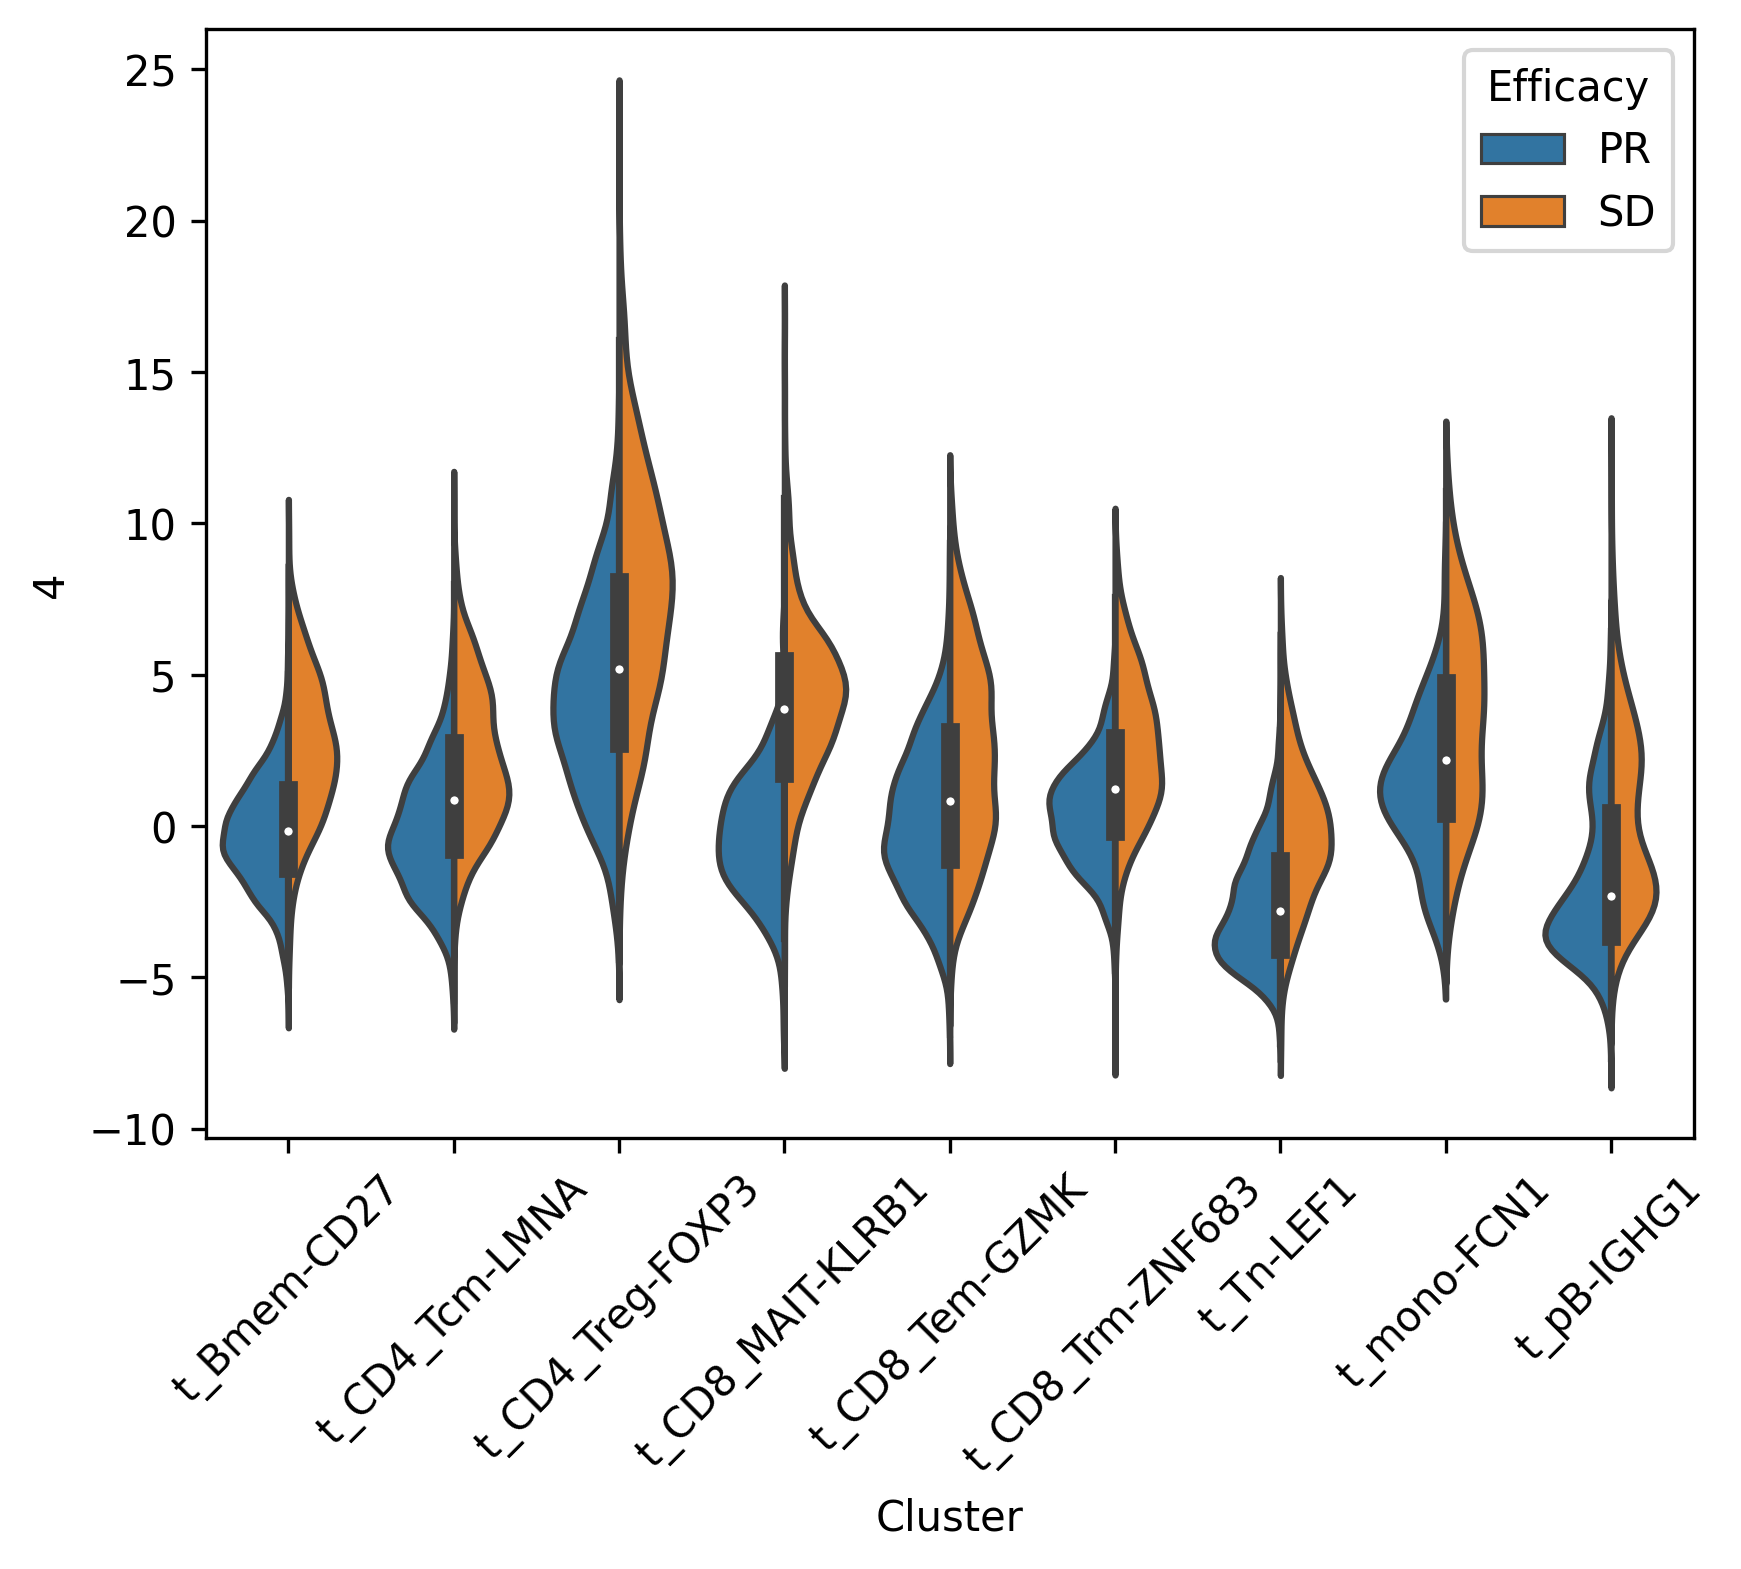

In [252]:
df = sc.get.obs_df(adata, ['Cluster','4', 'Efficacy'])
#df = df.set_index('Efficacy').stack().reset_index()
#df.columns = []
#df.columns = ['Efficacy', 'MCP', 'value']
#import seaborn as sns
#sns.violinplot(data=df, x='gene', y='value', hue="louvain",
#                split=True, inner="quart", linewidth=1)    

p2 = sns.violinplot(data=df, x="Cluster",y="4",hue="Efficacy", split=True)
p2.set_xticklabels(p2.get_xticklabels(), rotation=45)


[Text(0, 0, 't_Bmem-CD27'),
 Text(1, 0, 't_CD4_Tcm-LMNA'),
 Text(2, 0, 't_CD4_Treg-FOXP3'),
 Text(3, 0, 't_CD8_MAIT-KLRB1'),
 Text(4, 0, 't_CD8_Tem-GZMK'),
 Text(5, 0, 't_CD8_Trm-ZNF683'),
 Text(6, 0, 't_Tn-LEF1'),
 Text(7, 0, 't_mono-FCN1'),
 Text(8, 0, 't_pB-IGHG1')]

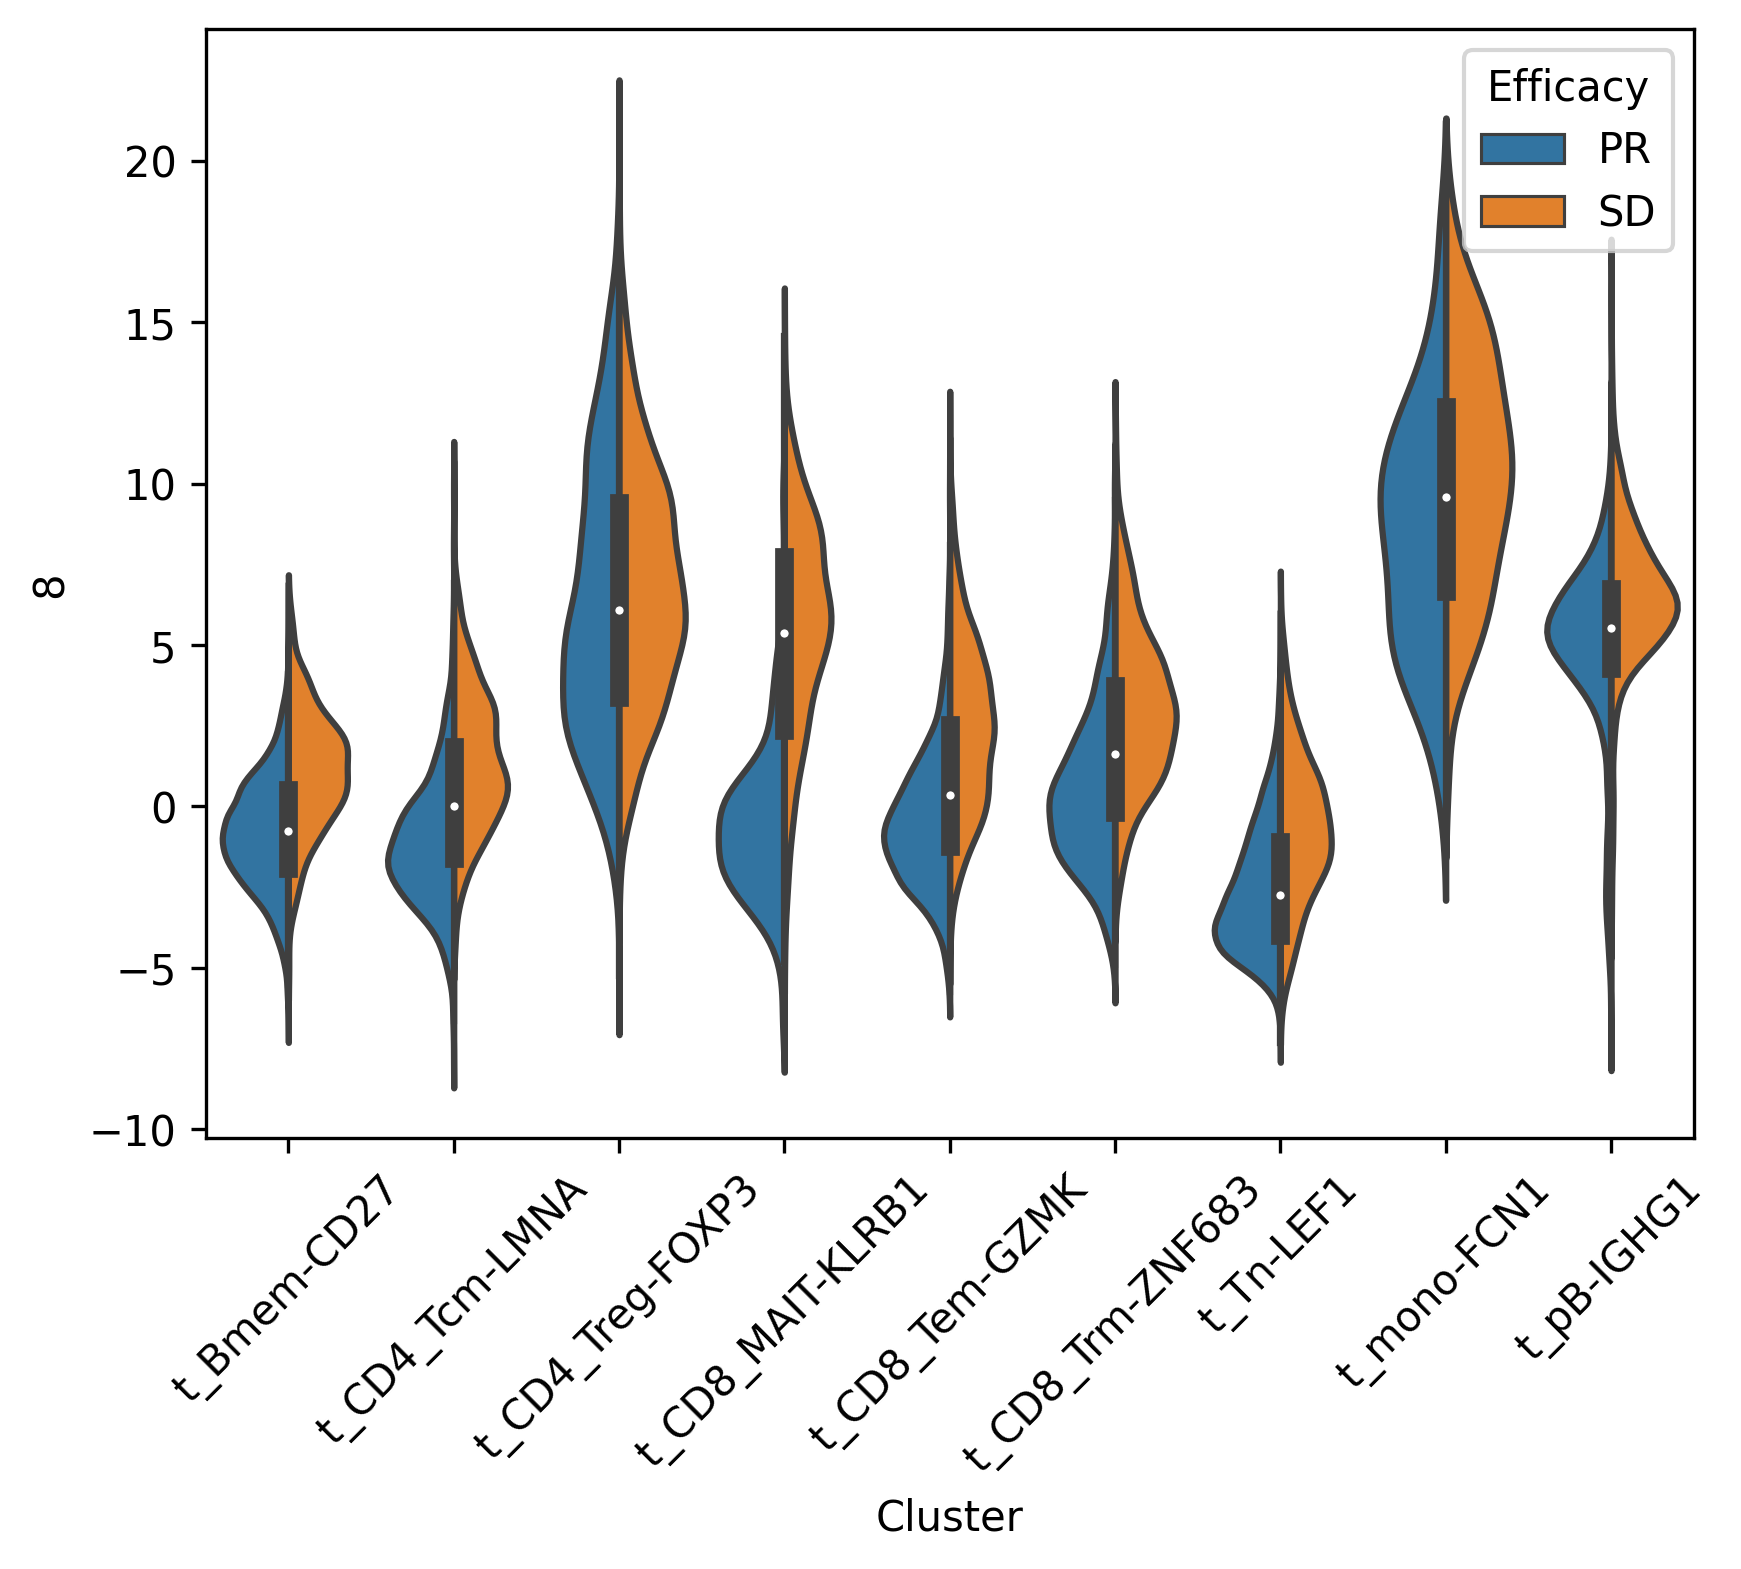

In [253]:
df = sc.get.obs_df(adata, ['Cluster','8', 'Efficacy'])
#df = df.set_index('Efficacy').stack().reset_index()
#df.columns = []
#df.columns = ['Efficacy', 'MCP', 'value']
#import seaborn as sns
#sns.violinplot(data=df, x='gene', y='value', hue="louvain",
#                split=True, inner="quart", linewidth=1)    

p2 = sns.violinplot(data=df, x="Cluster",y="8",hue="Efficacy", split=True)
p2.set_xticklabels(p2.get_xticklabels(), rotation=45)

In [242]:
sc.get.obs_df(adata, ['Cluster','4', 'Efficacy'])

Cluster         4 Efficacy
Cell barcode                                               
AAATGCCTCATCTGCC.Pre_P007_t  t_Bmem-CD27 -2.364669       PR
AATCCAGAGCGTTCCG.Pre_P007_t  t_Bmem-CD27 -0.284651       PR
ACAGCCGAGCACCGCT.Pre_P007_t  t_Bmem-CD27 -0.978295       PR
ACCGTAAAGCTAACTC.Pre_P007_t  t_Bmem-CD27  1.087998       PR
ACGAGCCTCGTAGGTT.Pre_P007_t  t_Bmem-CD27 -1.083146       PR
...                                  ...       ...      ...
CGGGTCAGTTCCCGAG.Pre_P004_t   t_pB-IGHG1  8.585988       SD
GCTTGAACAGGCTGAA.Pre_P004_t   t_pB-IGHG1  1.445790       SD
GTCGGGTGTCCGAATT.Pre_P004_t   t_pB-IGHG1  5.622560       SD
TCATTTGTCAATACCG.Pre_P004_t   t_pB-IGHG1  1.665304       SD
TCTCATATCCAAAGTC.Pre_P004_t   t_pB-IGHG1 -0.539101       SD

[42550 rows x 3 columns]